In [5]:
# ux = overall impression of the platform and its usability
# llm = the perceived truthfullness of generated content
# cdss = sucess in purchase decision
# inf = Comprehensibility of generated content

In [6]:
# created multiplex table
import pandas as pd
import os
import re

csv_files = [file for file in os.listdir('.') if file.endswith('.csv')]

avgdf = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file,sep=';', index_col=False)

    # average column val
    df['Row_Average'] = df.select_dtypes(include='number').mean(axis=1)
    label = file.split("-")[0]
    label2 = num = re.findall(r'\d+', file)[0]
    avgdf[(label, f"iter{label2}")] = df['Row_Average']
avgdf.columns = pd.MultiIndex.from_tuples(avgdf.columns)
avgdf

cdss                 inf             llm          ux      
      iter1     iter2     iter1     iter2 iter1 iter2 iter1 iter2
0  3.000000  4.333333  3.333333  4.333333   3.2   4.4  3.50  4.75
1  2.666667  4.333333  3.333333  4.666667   2.0   4.8  4.50  5.00
2  3.666667  3.333333  3.666667  5.000000   4.4   5.0  4.00  5.00
3  4.333333  4.666667  4.666667  5.000000   4.4   4.6  4.25  4.75
4  1.666667  4.333333  3.666667  5.000000   4.0   4.0  4.00  4.00
5  3.666667       NaN  4.333333       NaN   4.4   NaN  5.00   NaN

In [7]:
import numpy as np

def fill_with_running_mean(col):
    filled = []
    for i, val in enumerate(col):
        if pd.notna(val):
            filled.append(val)
        else:
            prev_vals = [v for v in filled if not np.isnan(v)]
            mean_val = np.mean(prev_vals) if prev_vals else np.nan
            filled.append(mean_val)
    return pd.Series(filled, index=col.index)

for col in avgdf.columns:
    avgdf[col] = fill_with_running_mean(avgdf[col])
avgdf

cdss                 inf             llm          ux      
      iter1     iter2     iter1     iter2 iter1 iter2 iter1 iter2
0  3.000000  4.333333  3.333333  4.333333   3.2  4.40  3.50  4.75
1  2.666667  4.333333  3.333333  4.666667   2.0  4.80  4.50  5.00
2  3.666667  3.333333  3.666667  5.000000   4.4  5.00  4.00  5.00
3  4.333333  4.666667  4.666667  5.000000   4.4  4.60  4.25  4.75
4  1.666667  4.333333  3.666667  5.000000   4.0  4.00  4.00  4.00
5  3.666667  4.200000  4.333333  4.800000   4.4  4.56  5.00  4.70

In [8]:
col_means = avgdf.mean(axis=0, skipna=True)

avgdf.loc['Column_Avg'] = col_means

avgdf

cdss                 inf                 llm              ux  \
               iter1     iter2     iter1     iter2     iter1 iter2     iter1   
0           3.000000  4.333333  3.333333  4.333333  3.200000  4.40  3.500000   
1           2.666667  4.333333  3.333333  4.666667  2.000000  4.80  4.500000   
2           3.666667  3.333333  3.666667  5.000000  4.400000  5.00  4.000000   
3           4.333333  4.666667  4.666667  5.000000  4.400000  4.60  4.250000   
4           1.666667  4.333333  3.666667  5.000000  4.000000  4.00  4.000000   
5           3.666667  4.200000  4.333333  4.800000  4.400000  4.56  5.000000   
Column_Avg  3.166667  4.200000  3.833333  4.800000  3.733333  4.56  4.208333   

                  
           iter2  
0           4.75  
1           5.00  
2           5.00  
3           4.75  
4           4.00  
5           4.70  
Column_Avg  4.70

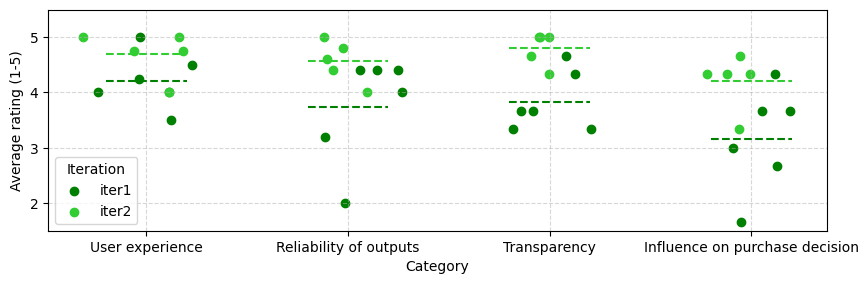

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))

colors = {"iter1": "green", "iter2": "limegreen"}


top_labels = list(avgdf.columns.levels[0])

top_labels.reverse()

for i, top_label in enumerate(top_labels):
    for sub_label in avgdf[top_label].columns:
        avg_val = avgdf.loc['Column_Avg', (top_label, sub_label)]

        plt.hlines(avg_val, i - 0.2, i + 0.2, colors=colors.get(sub_label, 'blue'), linestyles='dashed')
        y_values = avgdf[(top_label, sub_label)]

        if sub_label == 'iter1':
            y_values = y_values.iloc[:-1]
        elif sub_label == 'iter2':
            y_values = y_values.iloc[:-2]

        x_jitter = i + np.random.normal(0, 0.13, size=len(y_values))
        plt.scatter(x_jitter, y_values, color=colors.get(sub_label, 'blue'), label=sub_label if i == 0 else "")

label_map = {
    'ux': 'User experience',
    'llm': 'Reliability of outputs',
    'cdss': 'Influence on purchase decision',
    'inf': 'Transparency'
}

custom_labels = [label_map.get(lbl, lbl) for lbl in top_labels]

plt.xticks(range(len(top_labels)), custom_labels, rotation=0, ha='center')
plt.ylim(1.5, 5.5)
plt.ylabel("Average rating (1-5)")
plt.xlabel("Category")
# plt.title("Average rating by category and Iteration")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Iteration")
plt.tight_layout()
plt.show()

